In [1]:
# this lets us use the figures interactively
%matplotlib inline

#imports needed for project
import pandas as pd
import geopandas as gpd
import folium
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import json
from shapely.ops import nearest_points
from folium.features import CustomIcon



In [2]:
#shapefiles that will be used for the project
#we want to import these using GeoPandas 
greenspaces = gpd.read_file('datafiles/Greenspace_NI.shp')
wards = gpd.read_file('datafiles/NI_Wards.shp')
greenways = gpd.read_file('datafiles/greenways_belfast.shp')
belfast = gpd.read_file('datafiles/belfast_outline.shp')

In [3]:
# convert all shapefiles into epsg 29902
# epsg 29902 is the 
greenspaces = greenspaces.to_crs(epsg=29902)
wards = wards.to_crs(epsg=29902)
greenways = greenways.to_crs(epsg=29902)
belfast = belfast.to_crs(epsg=29902)


In [4]:
# creating a Universal Transverse Mercator reference system to ensure data is on the correct coordinate reference system
ni_utm = ccrs.UTM(29)

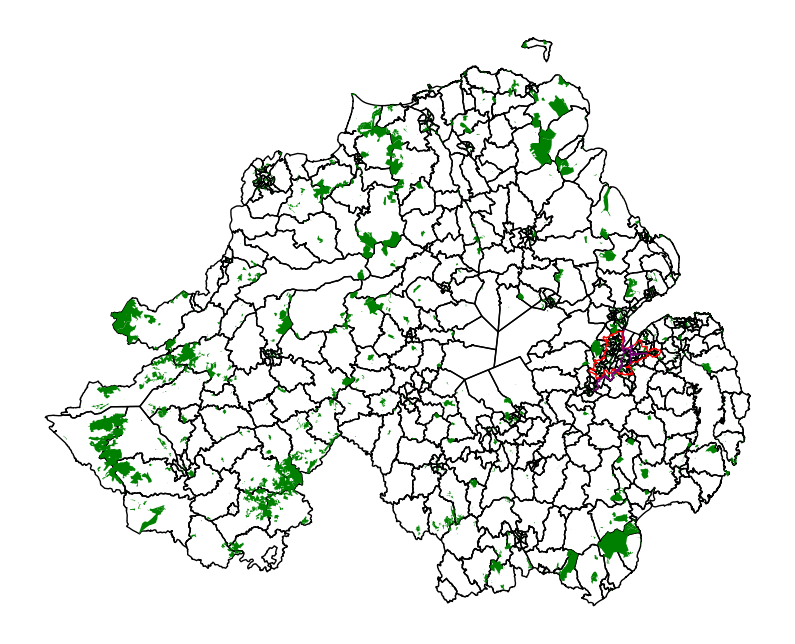

In [5]:
# to show all shapefiles have successfully loaded in the correct coordinate system we will create a static image with the shapefiles
#set up the plot with a specific size
myfig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ni_utm})

# each shapefile plotted on map, showing colour and label
wards.plot(ax=ax, color='none', edgecolor='black', label='Wards')
greenspaces.plot(ax=ax, color='green', label='Green Spaces')
greenways.plot(ax=ax, color='purple', label='Greenways', linewidth=1)
belfast.plot(ax=ax, color='none', edgecolor='red', linewidth=1, label='Belfast Outline')

#remove axis from the image
ax.set_axis_off()


# show the static map image
plt.show()

In [6]:
#this shows that all shapefiles have been import successfully and will be saved for reference 
myfig.savefig('staticmap', bbox_inches='tight', dpi=300)

In [7]:
#calculate the total area of greenspaces in Northern Ireland
sum_greenspaces = greenspaces['Area_Ha'].sum()

#print the total area
print(sum_greenspaces)

85818.3144534194


In [8]:
#clip the shapefiles to the Belfast boundary
belfast_wards = gpd.clip(wards, belfast)
belfast_greenspaces = gpd.clip(greenspaces, belfast)
belfast_greenways = gpd.clip(greenways, belfast)

In [9]:
belfast_greenspaces = belfast_greenspaces.to_crs(epsg=29902)
belfast_greenways = belfast_greenways.to_crs(epsg=29902)
belfast_wards = belfast_wards.to_crs(epsg=29902)

In [10]:
belfast_wards.crs

<Projected CRS: EPSG:29902>
Name: TM65 / Irish Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Ireland - onshore.
- bounds: (-10.56, 51.39, -5.93, 55.43)
Coordinate Operation:
- name: Irish Grid
- method: Transverse Mercator
Datum: TM65
- Ellipsoid: Airy Modified 1849
- Prime Meridian: Greenwich

In [11]:
belfast_wards.head()

Ward Code          Ward  Population  \
461    95SS19        Lambeg        2737   
476    95SS27  Seymour Hill        2502   
90     95GG45  Upper Malone        4841   
232    95GG23       Finaghy        4555   
284    95II18    Minnowburn        2226   

                                              geometry  
461  POLYGON ((328412.688 367259.031, 328417.001 36...  
476  POLYGON ((329294.094 367835.813, 329285.188 36...  
90   POLYGON ((331008.688 368692.531, 331008.938 36...  
232  POLYGON ((330907.001 369055.500, 330907.938 36...  
284  POLYGON ((333880.407 368650.000, 333880.126 36...

In [12]:
# this will create a folium map with coordinates focused on Belfast, which our shapefiles are clipped too.
m = folium.Map(location=[54.5973, -5.9301], zoom_start=11)  # zoom level can be adjusted


# add in Belfast Wards
folium.GeoJson(
    belfast_wards,
    name='Wards',
    tooltip=folium.GeoJsonTooltip(fields=['Ward', 'Population']),
    popup=folium.GeoJsonPopup(fields=['Ward', 'Population']) #this will popup the ward name and population
).add_to(m)

# add Belfast greenspaces
folium.GeoJson(
    belfast_greenspaces,
    name='Greenspaces',
    style_function=lambda x: {'color': 'green', 'weight': 3, 'fillColor': 'green', 'fillOpacity': 0.5},
    tooltip=folium.GeoJsonTooltip(fields=['Name', 'Area_Ha']),
    popup=folium.GeoJsonPopup(fields=['Name', 'Area_Ha'])
).add_to(m)


# add Belfast greenways
folium.GeoJson(
    belfast_greenways,
    name='Greenways',
    style_function=lambda x: {'color': 'purple', 'weight': 3, 'fillColor': 'purple', 'fillOpacity': 0.5},
    tooltip=folium.GeoJsonTooltip(fields=['Name']) #this will popup the greenway name
).add_to(m)

# add layer control to toggle each shapefile on and off
folium.LayerControl().add_to(m)

# display the map
m

In [13]:
#we can save a the map for reference
m.save('myproj_map.html')

In [14]:
#next we want to calculate the amount of greenspace within each ward. 
#the problem is that the belfast_greenspaces' area is calculated as hectares
#we need to change the area from hectares to km2 in order to get an accurate measure
belfast_greenspaces['Greenspace_km2'] = belfast_greenspaces['Area_Ha'] / 100.0

In [15]:
print(belfast_greenspaces[['Area_Ha', 'Greenspace_km2']].head())

        Area_Ha  Greenspace_km2
1107   0.571995        0.005720
1109   2.192751        0.021928
1411  14.590809        0.145908
1148   0.691673        0.006917
172    6.987865        0.069879


In [16]:
intersections = gpd.overlay(belfast_wards, belfast_greenspaces, how='intersection')

In [17]:
intersections['Intersection_Area_km2'] = intersections.geometry.area / 1e6

In [18]:
intersections

Ward Code          Ward  Population SourceID  \
0      95SS19        Lambeg        2737   702689   
1      95SS19        Lambeg        2737   702780   
2      95SS19        Lambeg        2737   702782   
3      95SS27  Seymour Hill        2502   702782   
4      95SS27  Seymour Hill        2502   702504   
..        ...           ...         ...      ...   
207    95GG40      Shankill        3816     None   
208    95GG28     Highfield        5651     None   
209    95GG28     Highfield        5651   405393   
210    95GG28     Highfield        5651     None   
211    95GG51      Woodvale        4088     None   

                                       GUID                      Name  \
0    {758e3844-eaf3-45ac-9fd2-0cac15c7bede}                      None   
1    {8a463e95-2f7d-4ebd-834f-7840d703274f}                      None   
2    {fb07e7d7-1737-4f43-b6fb-c03640352e16}                      None   
3    {fb07e7d7-1737-4f43-b6fb-c03640352e16}                      None   
4    {6dbaffd4-8859-4ac5-accc-c21bcc56c2a4}                      None   
..                                      ...                       ...   
207  {cafbd09d-7d98-4832-8360-6b8fbd0d2732}              Peter's Hill   
208  {5403d772-e4bc-43eb-af58-6dc20dd621b4}  Highpark/Highcairn Green   
209  {b2014d87-e0e0-4066-a175-ceb1a4d34bc2}                      None   
210  {094156ab-5dca-40a7-b962-845204cfcdb8}            Highpark Cross   
211  {18b56d7f-ac29-43d9-ba05-2a5e53b1a93a}             Woodvale Park   

                   Source            Category               Type PaidAccess  \
0                    NIHE  Amenity Greenspace  Public Open Space         No   
1                    NIHE  Amenity Greenspace  Public Open Space         No   
2                    NIHE  Amenity Greenspace  Public Open Space         No   
3                    NIHE  Amenity Greenspace  Public Open Space         No   
4                    NIHE  Amenity Greenspace  Public Open Space         No   
..                    ...                 ...                ...        ...   
207  Belfast City Council  Amenity Greenspace  Public Open Space         No   
208                  NIHE  Amenity Greenspace  Public Open Space         No   
209                  NIHE  Amenity Greenspace  Public Open Space         No   
210                  NIHE  Amenity Greenspace  Public Open Space         No   
211  Belfast City Council   Parks and Gardens        Public Park         No   

      Area_Ha Update_Dat      Verified ShowOnMap  ORNI_ID  Greenspace_km2  \
0    0.571995       None  Approximated       Yes     2631        0.005720   
1    2.192751       None  Approximated       Yes     2633        0.021928   
2    0.550867       None  Approximated       Yes     2626        0.005509   
3    0.550867       None  Approximated       Yes     2626        0.005509   
4    2.203366       None  Approximated       Yes     2625        0.022034   
..        ...        ...           ...       ...      ...             ...   
207  1.535606       None  Approximated       Yes      312        0.015356   
208  0.587995       None  Approximated       Yes      313        0.005880   
209  0.563588       None  Approximated       Yes     2914        0.005636   
210  0.663443       None  Approximated       Yes      315        0.006634   
211  9.517357       None  Approximated       Yes      280        0.095174   

                                              geometry  Intersection_Area_km2  
0    POLYGON Z ((328685.091 367235.932 0.000, 32867...               0.000044  
1    POLYGON Z ((329248.552 367784.388 0.000, 32924...               0.001055  
2    MULTIPOLYGON Z (((328995.376 367730.375 0.000,...               0.004210  
3    MULTIPOLYGON Z (((329003.782 367739.750 0.000,...               0.001299  
4    POLYGON Z ((329108.942 368038.144 0.000, 32910...               0.022034  
..                                                 ...                    ...  
207  POLYGON Z ((333369.995 375101.118 0.000, 33337...              

In [19]:
intersections = intersections.to_crs(epsg=29902)

In [20]:
greenspace_by_ward = intersections.groupby('Ward')['Intersection_Area_km2'].sum().reset_index()
greenspace_by_ward.rename(columns={'Intersection_Area_km2': 'Total_Greenspace_km2'}, inplace=True)

In [21]:
print(greenspace_by_ward.sort_values('Total_Greenspace_km2', ascending=False))

                        Ward  Total_Greenspace_km2
56                  Stormont              0.812640
4                   Beechill              0.524769
57               Stranmillis              0.442827
51                 Ravenhill              0.402108
28                Falls Park              0.396920
..                       ...                   ...
11                Cairnshill              0.004784
9   Bloomfield (Belfast LGD)              0.004105
6                   Bellevue              0.000932
16           Chichester Park              0.000528
44             Lower Braniel              0.000029

[68 rows x 2 columns]


In [22]:
belfast_wards['area_km2'] = belfast_wards.geometry.area / 1e6  # convert from m² to km²

In [23]:
belfast_wards['population_density'] = belfast_wards['Population'] / belfast_wards['area_km2']

In [24]:
belfast_wards = belfast_wards.merge(greenspace_by_ward, on='Ward', how='left')

In [25]:
belfast_wards['greenspace_per_pop_density'] = belfast_wards['Total_Greenspace_km2'] / belfast_wards['population_density']

In [26]:
belfast_wards

Ward Code          Ward  Population  \
0     95SS19        Lambeg        2737   
1     95SS27  Seymour Hill        2502   
2     95GG45  Upper Malone        4841   
3     95GG23       Finaghy        4555   
4     95II18    Minnowburn        2226   
..       ...           ...         ...   
76    95GG21         Falls        5184   
77    95GG18       Clonard        4975   
78    95GG40      Shankill        3816   
79    95GG28     Highfield        5651   
80    95GG51      Woodvale        4088   

                                             geometry  area_km2  \
0   POLYGON ((328412.688 367259.031, 328417.001 36...  0.194642   
1   POLYGON ((329294.094 367835.813, 329285.188 36...  0.635427   
2   POLYGON ((331008.688 368692.531, 331008.938 36...  1.744020   
3   POLYGON ((330907.001 369055.500, 330907.938 36...  1.022610   
4   POLYGON ((333880.407 368650.000, 333880.126 36...  0.938379   
..                                                ...       ...   
76  POLYGON ((331866.688 373449.063, 331865.657 37...  1.199964   
77  POLYGON ((332417.782 374159.344, 332413.719 37...  0.610970   
78  POLYGON ((332612.251 374539.250, 332605.032 37...  0.926982   
79  POLYGON ((331130.876 374259.375, 331114.907 37...  1.423182   
80  POLYGON ((331691.344 374560.063, 331690.688 37...  0.572059   

    population_density  Total_Greenspace_km2  greenspace_per_pop_density  
0         14061.696474              0.005309                3.775664e-07  
1          3937.510654              0.085303                2.166429e-05  
2          2775.770346              0.150758                5.431207e-05  
3          4454.288646              0.078144                1.754358e-05  
4          2372.176933              0.367699                1.550051e-04  
..                 ...                   ...                         ...  
76         4320.128201              0.025025                5.792547e-06  
77         8142.790913              0.047671                5.854354e-06  
78         4116.586926              0.039513                9.598477e-06  
79         3970.679014              0.018150                4.571072e-06  
80         7146.118649              0.095174                1.331822e-05  

[81 rows x 8 columns]

In [27]:
belfast_wards['centroid'] = belfast_wards.geometry.centroid

In [28]:
def get_nearest_greenway(row, point_column='geometry', value_column="geometry"):
    """Find the nearest point and return the corresponding value from specified value column."""

    # Create an union of the other GeoDataFrame's geometries:
    greenways_union = greenways["geometry"].unary_union

    centroid = row['centroid']

    nearest_point = nearest_points(centroid, greenways_union)[1]

    # Find the nearest points
    nearest_geoms = nearest_points(centroid, greenways_union)[1]
    
    return centroid.distance(nearest_point) / 1000

In [29]:
belfast_wards["distance_from_greenway"] = belfast_wards.apply(get_nearest_greenway, axis=1)

In [30]:
print(belfast_wards.sort_values('distance_from_greenway', ascending=True))

   Ward Code                      Ward  Population  \
34    95GG30                     Knock        4827   
26    95II08                 Downshire        2417   
54    95GG29                    Island        5014   
4     95II18                Minnowburn        2226   
37    95GG11  Bloomfield (Belfast LGD)        5453   
..       ...                       ...         ...   
46    95GG26                 Glencairn        3749   
66    95GG25                 Glen Road        5573   
71    95GG27                 Glencolin        6498   
52    95GG32                  Legoniel        6409   
72    95GG46         Upper Springfield        5250   

                                             geometry  area_km2  \
34  POLYGON ((338188.782 372756.375, 338182.813 37...  1.119074   
26  POLYGON ((336616.313 371424.875, 336619.657 37...  0.442899   
54  POLYGON ((336965.719 374337.938, 336964.282 37...  1.410373   
4   POLYGON ((333880.407 368650.000, 333880.126 36...  0.938379   
37  POLYGON ((33

In [43]:
belfast_wards

Ward Code          Ward  Population  \
0     95SS19        Lambeg        2737   
1     95SS27  Seymour Hill        2502   
2     95GG45  Upper Malone        4841   
3     95GG23       Finaghy        4555   
4     95II18    Minnowburn        2226   
..       ...           ...         ...   
76    95GG21         Falls        5184   
77    95GG18       Clonard        4975   
78    95GG40      Shankill        3816   
79    95GG28     Highfield        5651   
80    95GG51      Woodvale        4088   

                                             geometry  area_km2  \
0   POLYGON ((-6.01682 54.53740, -6.01675 54.53744...  0.194642   
1   POLYGON ((-6.00295 54.54235, -6.00309 54.54239...  0.635427   
2   POLYGON ((-5.97610 54.54960, -5.97609 54.54970...  1.744020   
3   POLYGON ((-5.97751 54.55289, -5.97749 54.55287...  1.022610   
4   POLYGON ((-5.93177 54.54847, -5.93177 54.54846...  0.938379   
..                                                ...       ...   
76  POLYGON ((-5.96072 54.59208, -5.96073 54.59212...  1.199964   
77  POLYGON ((-5.95188 54.59832, -5.95194 54.59829...  0.610970   
78  POLYGON ((-5.94870 54.60168, -5.94881 54.60168...  0.926982   
79  POLYGON ((-5.97173 54.59955, -5.97198 54.59944...  1.423182   
80  POLYGON ((-5.96293 54.60210, -5.96294 54.60209...  0.572059   

    population_density  Total_Greenspace_km2  greenspace_per_pop_density  \
0         14061.696474              0.005309                3.775664e-07   
1          3937.510654              0.085303                2.166429e-05   
2          2775.770346              0.150758                5.431207e-05   
3          4454.288646              0.078144                1.754358e-05   
4          2372.176933              0.367699                1.550051e-04   
..                 ...                   ...                         ...   
76         4320.128201              0.025025                5.792547e-06   
77         8142.790913              0.047671                5.854354e-06   
78         4116.586926              0.039513                9.598477e-06   
79         3970.679014              0.018150                4.571072e-06   
80         7146.118649              0.095174                1.331822e-05   

                         centroid  distance_from_greenway  
0   POINT (328852.774 367529.819)                0.309719  
1   POINT (329055.128 368165.177)                0.594186  
2   POINT (332048.766 369516.709)                0.490483  
3   POINT (330384.105 369342.805)                1.490262  
4   POINT (333306.247 368962.497)                0.149661  
..                            ...                     ...  
76  POINT (332809.558 373992.581)                1.602444  
77  POINT (331828.975 374200.981)                2.528862  
78  POINT (332738.386 374792.659)                1.618692  
79  POINT (330780.082 374872.871)                3.572517  
80  POINT (331676.927 375241.064)                2.729977  

[81 rows x 10 columns]

In [81]:
df = pd.read_csv('datafiles/belfast_bikestations.csv') # read the csv data

# create a new geodataframe
bike_stations = gpd.GeoDataFrame(df[['Location']], # use the csv data, but only the name/website columns
                            geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']), # set the geometry using points_from_xy
                            crs='epsg:4326') # set the CRS using a text representation of the EPSG code for WGS84 lat/lon

bike_stations.head() # show the new geodataframe

Location                   geometry
0                         City Hall  POINT (-5.92995 54.59700)
1   Victoria Square/Victoria Street  POINT (-5.92309 54.59820)
2                     Donegall Quay  POINT (-5.92104 54.60150)
3        Lanyon Station/Mays Meadow  POINT (-5.91545 54.59520)
4  St George's Market/Cromac Square  POINT (-5.92243 54.59510)

In [82]:
# add the airport points to the existing map
bike_stations.explore('Location',
                 marker_type='marker', # use a marker for the points, instead of a circle
                 popup=True, # show the information as a popup when we click on the marker
                 legend=False, # don't show a separate legend for the point layer
                )

In [83]:
bike_stations= bike_stations.to_crs(epsg=4326)
belfast_wards= belfast_wards.to_crs(epsg=4326)

In [84]:
def distance_to_nearest_bike_station(row, point_column='geometry', value_column="geometry"):
    """Find the nearest point and return the corresponding value from specified value column."""

    # Create an union of the other GeoDataFrame's geometries:
    bike_stations_union = bike_stations["geometry"].unary_union

    centroid = row['centroid']

    nearest_point = nearest_points(centroid,  bike_stations_union)[1]

    # Find the nearest points
    nearest_geoms = nearest_points(centroid,  bike_stations_union)[1]
    
    return centroid.distance(nearest_point)

In [85]:
belfast_wards["distance_to_nearest_bike_station"] = belfast_wards.apply(distance_to_nearest_bike_station, axis=1)

In [86]:
print(belfast_wards.sort_values('distance_to_nearest_bike_station', ascending=True))

   Ward Code             Ward  Population  \
70    95GG12          Botanic        8945   
73    95GG39      Shaftesbury        7214   
78    95GG40         Shankill        3816   
76    95GG21            Falls        5184   
39    95GG04   Ballymacarrett        4908   
..       ...              ...         ...   
42    95II09        Dundonald        3363   
9     95SS07        Derryaghy        9464   
20    95II13  Graham's Bridge        2702   
19    95II10            Enler        2592   
41    95II04      Carrowreagh        4317   

                                             geometry  area_km2  \
70  POLYGON ((-5.92807 54.57948, -5.92807 54.57946...  1.304289   
73  POLYGON ((-5.93936 54.58669, -5.93953 54.58657...  2.232264   
78  POLYGON ((-5.94870 54.60168, -5.94881 54.60168...  0.926982   
76  POLYGON ((-5.96072 54.59208, -5.96073 54.59212...  1.199964   
39  POLYGON ((-5.90665 54.59524, -5.90694 54.59526...  0.780308   
..                                                ...    

In [87]:
if 'centroid' in belfast_wards.columns:
    belfast_wards = belfast_wards.drop(columns=['centroid'])

In [88]:
belfast_greenspaces = belfast_greenspaces.to_crs(epsg=4326)
belfast_greenways = belfast_greenways.to_crs(epsg=4326)
belfast_wards = belfast_wards.to_crs(epsg=4326)

In [94]:

final_map = folium.Map(location=[54.5973, -5.9301], zoom_start=11)


# add in Belfast Wards
folium.GeoJson(
    belfast_wards,
    name='Wards',
tooltip=folium.GeoJsonTooltip(
        fields=['Ward', 'Total_Greenspace_km2', 'greenspace_per_pop_density', 'distance_from_greenway', 'distance_to_nearest_bike_station'],
        aliases=['Ward', 'Total Greenspace (km²)', 'Greenspace per Population Density', 'Distance from Greenway (km)', 'Distance to Nearest Bike Station (km)']
    ),
    popup=folium.GeoJsonPopup(
        fields=['Ward', 'Total_Greenspace_km2', 'greenspace_per_pop_density', 'distance_from_greenway', 'distance_to_nearest_bike_station'],
        aliases=['Ward', 'Total Greenspace (km²)', 'Greenspace per Population Density', 'Distance from Greenway (km)', 'Distance to Nearest Bike Station (km)'],
  )
).add_to(final_map)

# add Belfast greenspaces
folium.GeoJson(
    belfast_greenspaces,
    name='Greenspaces',
    style_function=lambda x: {'color': 'green', 'weight': 3, 'fillColor': 'green', 'fillOpacity': 0.5},
    tooltip=folium.GeoJsonTooltip(fields=['Name', 'Area_Ha']),
    popup=folium.GeoJsonPopup(fields=['Name', 'Area_Ha'])
).add_to(final_map)


# add Belfast greenways
folium.GeoJson(
    belfast_greenways,
    name='Greenways',
    style_function=lambda x: {'color': 'purple', 'weight': 3, 'fillColor': 'purple', 'fillOpacity': 0.5},
    tooltip=folium.GeoJsonTooltip(fields=['Name']) #this will popup the greenway name
).add_to(final_map)

# Add Bike Stations
for idx, row in bike_stations.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=f"Station: {row['Location']}",
        icon=folium.Icon(icon='bicycle', prefix='fa', color='red')
    ).add_to(final_map)

# Add Layer Control
folium.LayerControl().add_to(final_map)

# Display the map
final_map